notebook performs PCA and targeted dimensionality reduction on hidden unit activity of RNN agents and saves related plots (3D, scatter, stay/switch accuracy)

In [1]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import ptitprince as pt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# figure defaults
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['axes.grid'] = True

In [2]:
#move up in directory
os.chdir('../')

In [3]:
os.getcwd()

'C:\\Users\\deniz\\Desktop\\PhD\\p1_generalization'

In [4]:
# CONFIG

PATH_RNN_DATA ='data/rnn_raw_data/'
RNN_FILE_NAME = 'lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'

# number of RNN instances
N_IDS = 30
# number of random walk instances
N_WALKS = 3
# number of trials per episode
N_TRIALS = 300
# number of actions/bandits
N_ACTIONS = 4

In [5]:
def get_unique_bandit_heuristic(my_choice, choice):
    
    n_trials = len(choice)
    other_choices = []
    unq_b_vec = np.zeros(n_trials)

    for t in range(n_trials):
        if choice[t] != -1: # if -1 choice is invalid
            if choice[t] != my_choice:

                other_choices.append(choice[t])
                unq_b_vec[t] = len(np.unique(other_choices))

            if choice[t] == my_choice:

                other_choices = []
                unq_b_vec[t] = 0
                
    return(unq_b_vec)

# Stay vs Switch Choice predictions (PCA)

In [6]:
rnn_file_path = PATH_RNN_DATA + RNN_FILE_NAME

# collect switch trials
is_switch = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# collect choice predictions
choice_preds = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for choices for all RNN instances
all_choices = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for correct choice predictions
accuracy = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for correct choice predictions
switch_accuracy = np.zeros([N_IDS*N_WALKS])
# container for correct choice predictions
stay_accuracy = np.zeros([N_IDS*N_WALKS])
# container for accuracy by #unique bandits
unq_acc = np.zeros([N_IDS*N_WALKS,3])


for walk in range(1, N_WALKS+1):
     for id_ in range(N_IDS):


        # get data from RNN instance
        d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
        df = d.reset_index()
        # get choices
        choices = df.choice.to_numpy()
        # extract hidden unit activity
        hidden_units = df.loc[:, [col.startswith('rnn_state') for col in df.columns.values]]
        # init pca object
        pca = PCA()
        # standardize hidden unit activity
        st_hidden = StandardScaler().fit_transform(hidden_units)  
        # predictor X is principal components
        X = pca.fit_transform(st_hidden)

        ##################################################
        # choice predictions with multinomial regression 
        ##################################################


        # get choices
        y = np.array(df.choice)
        # create multinomial model
        model = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', max_iter=500).fit(X,y)
        # create prediction
        model.predict(X)


        # save choice predictions for all actions
        choice_preds[(walk-1)*N_IDS+id_,:] = model.predict(X)

        #########################
        # variable collection 
        #########################

        # get switch trials 
        is_switch[(walk-1)*N_IDS+id_, :] = df.is_switch.to_numpy()

        # get choices
        all_choices[(walk-1)*N_IDS+id_, :] = choices

        # get accuracy
        accuracy[(walk-1)*N_IDS+id_, :] = choices == model.predict(X)
        
        # get switch accuracy
        switch_accuracy[(walk-1)*N_IDS+id_] = np.mean((choices == model.predict(X))[df.is_switch.to_numpy()==1])
        
        # get stay accuracy
        stay_accuracy[(walk-1)*N_IDS+id_] = np.mean((choices == model.predict(X))[df.is_switch.to_numpy()==0])


        ###############
        # unique bandit heuristic
        ###############

        # uncertainty value at t
        unq_bandit_array = np.zeros([len(choices),N_ACTIONS])
        # shift 1 to get uncertainty value t-1 for choice t
        shifted_unq_bandit_array = np.zeros([len(choices),N_ACTIONS])

        for b in range(N_ACTIONS):
            unq_bandit_array[:,b] = get_unique_bandit_heuristic(my_choice = b, choice = choices)
            shifted_unq_bandit_array[:,b] = pd.Series(unq_bandit_array[:,b]).shift(1)

        # get shifted uncertainty of chosen actions
        lagged_ch_unc = [shifted_unq_bandit_array[t,:][choices[t]] for t in range(len(choices))]

        unq_df = pd.DataFrame({'acc': accuracy[(walk-1)*N_IDS+id_, :], 'unc': lagged_ch_unc})
        
        unq_acc[(walk-1)*N_IDS+id_,:] = unq_df.groupby('unc').mean().values[1:,:].flatten()


In [7]:
# styling for following plots
plt.rcParams["figure.figsize"] = (7, 7)

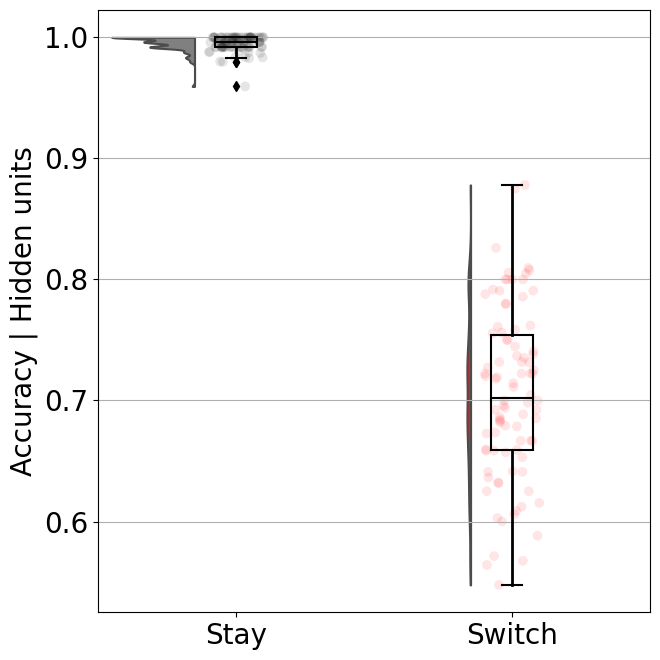

In [8]:
# stay_switch_accuracy = df.groupby(['id', 'walk','is_switch']).mean()
# df = stay_switch_accuracy.reset_index()

# switch_accuracy = df[df['is_switch']==1]['preds'].to_numpy()
# stay_accuracy = df[df['is_switch']==0]['preds'].to_numpy()

# plotting
plot_df = pd.DataFrame({"accuracy": list(stay_accuracy) + list(switch_accuracy),
                       "type": ['Stay'] * len(stay_accuracy)  + ['Switch'] * len(switch_accuracy)})

# plotting the clouds
f, ax = plt.subplots()
dy="accuracy"; dx="type"; ort="v"; pal = {"Stay": "grey", "Switch": "red"}#sns.color_palette(n_colors=2)
ax=pt.half_violinplot( x = dx, y = dy, data = plot_df, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)


pal1 = {"Stay": "black", "Switch": "red"}
ax=sns.stripplot( x = dx, y = dy, data = plot_df, palette = pal1, edgecolor = "white",
size = 7, jitter = 1, zorder = 0, orient = ort, alpha = 0.1)

x=sns.boxplot( x = dx, y = dy, data = plot_df, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)

plt.ylabel('Accuracy | Hidden units')
plt.xlabel('')

plt.tight_layout()

plt.savefig('../p1_generalization/plots/figure_5_F.svg', dpi = 600)

In [10]:
plot_df.groupby('type').median()

,accuracy
type,
Stay,0.996154
Switch,0.702273


In [11]:
# save data for jasp analysis
plot_df = plot_df[plot_df['type']=='Switch']
plot_df.to_csv('data/intermediate_data/jasp_analysis/switch_accuracy_t_test_data.csv')

In [9]:
rnn_file_path = PATH_RNN_DATA + RNN_FILE_NAME

choice_axis = np.zeros([N_IDS*N_WALKS,N_TRIALS, N_ACTIONS])
switch_axis = np.zeros([N_IDS*N_WALKS,N_TRIALS])
value_axis = np.zeros([N_IDS*N_WALKS,N_TRIALS])
prev_rew = np.zeros([N_IDS*N_WALKS,N_TRIALS])

i = 0
for walk in range(1, N_WALKS+1):
    for id_ in range(N_IDS):

        d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
        df = d.reset_index()

        # extract hidden unit activity
        hidden_units = df.loc[:, [col.startswith('rnn_state') for col in df.columns.values]]
        # init pca object
        pca = PCA()
        # standardize hidden unit activity
        st_hidden = StandardScaler().fit_transform(hidden_units)  
        # predictor X is principal components
        X = pca.fit_transform(st_hidden)
        
        
        # onehot encoding for choices
        oh_choices = pd.get_dummies(df.choice).to_numpy()

        for a in range(N_ACTIONS):

            # binary logistic regression for each action
            y = oh_choices[:,a]
            # binary logistic regressions to get axis
            clf = LogisticRegression(random_state=0).fit(X, y)
            # get linear combination as axis
            choice_axis[(walk-1)*N_IDS+id_,:,a] = np.dot(X,np.transpose(clf.coef_)).flatten()
            
        # binary logistic regression for switches
        y = df.is_switch
        clf = LogisticRegression(random_state=0).fit(X, y)
        # get linear combination as axis
        switch_axis[(walk-1)*N_IDS+id_, :] = np.dot(X,np.transpose(clf.coef_)).flatten()
        
        # linear regression for values
        y = df.value
        # binary logistic regressions to get axis
        lr = LinearRegression().fit(X, y)
        # get linear combination as axis
        value_axis[(walk-1)*N_IDS+id_, :] = np.dot(X,np.transpose(lr.coef_)).flatten()

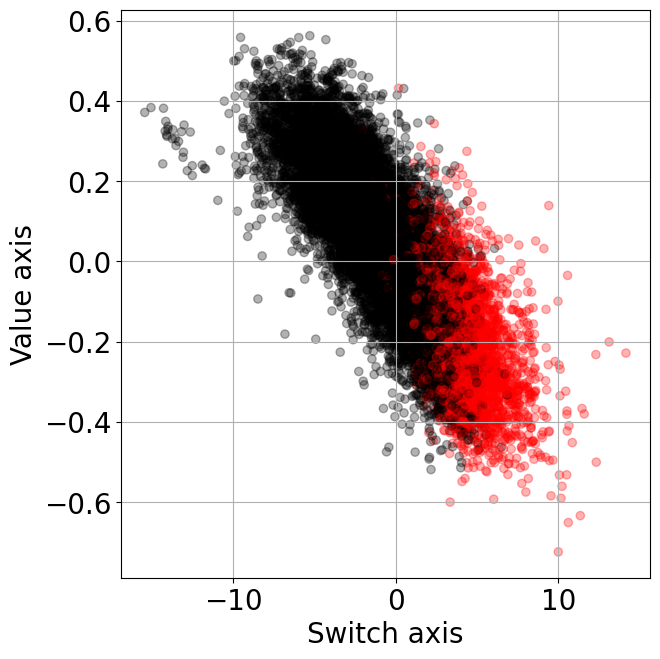

In [10]:
# create color for switches
my_sw_cols = ['black', 'red']
sw_col = [my_sw_cols[int(is_switch.flatten()[t])] for t in range(np.shape(is_switch.flatten())[0])]

plt.scatter(switch_axis, value_axis, c = sw_col, alpha = 0.3)
plt.xlabel('Switch axis')
plt.ylabel('Value axis')
plt.tight_layout()

#plt.savefig('../p1_generalization/plots/fig_5_E.png', dpi = 600)

In [ ]:
# save data for jasp analysis
plot_df = pd.DataFrame({"switch_axis": switch_axis.flatten(),
                       "value_axis":value_axis.flatten()})

plot_df.to_csv('data/intermediate_data/jasp_analysis/switch_axis_value_axis_data.csv')

In [ ]:
np.corrcoef(x = switch_axis.flatten(), y = value_axis.flatten())

In [11]:
plt.scatter(prev_rew[:,1:], value_axis[:,1:], c = values[:,1:].flatten(), cmap = 'inferno', alpha = 0.3)
plt.xlabel('Previous Reward')
plt.ylabel('Value axis')
plt.tight_layout()

#plt.savefig('../p1_generalization/plots/fig_5_D.png', dpi = 600)

NameError: name 'values' is not defined

In [ ]:
# save data for jasp analysis
plot_df = pd.DataFrame({"previous_reward": prev_rew[:,1:].flatten(),
                       "value_axis":value_axis[:,1:].flatten()})

plot_df.to_csv('data/intermediate_data/jasp_analysis/previous_reward_value_axis_data.csv')


In [ ]:
np.corrcoef(x = prev_rew[:,1:].flatten(), y = value_axis[:,1:].flatten())

# Analysis regarding unique bandit heuristic

In [15]:
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (7, 7)

for i in range(np.shape(unq_acc)[0]):
    plt.plot(range(1,N_ACTIONS), unq_acc[i,:], '-o', c = 'lightblue', linewidth=1)

plt.plot(range(1,N_ACTIONS), np.mean(unq_acc, axis = 0), '-o', c = 'blue',  linewidth=5.)
plt.xticks(np.arange(1,N_ACTIONS, 1))
plt.ylabel("Switch Accuracy | Hidden Units)")
plt.xlabel("# Unique Bandits")

plt.savefig('../p1_generalization/plots/fig_5_F_new_with_multinomials.png', dpi = 600)

NameError: name 'unq_acc' is not defined

# 3D Plots

In [48]:
# plt.rcParams.update({'font.size': 12.5})
# plt.rcParams["figure.figsize"] = (25, 60)# before good(45, 60) (30,45)
# plt.rcParams['axes.grid'] = True


plt.rcParams.update({'font.size': 12.5})
plt.rcParams["figure.figsize"] = (30, 45)
plt.rcParams['axes.grid'] = True

In [49]:
# plotting settings
# my_dot_size = 70#10
# my_alpha = 1
# my_font_size = 30

# plotting settings
my_dot_size = 10
my_alpha = 1

C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


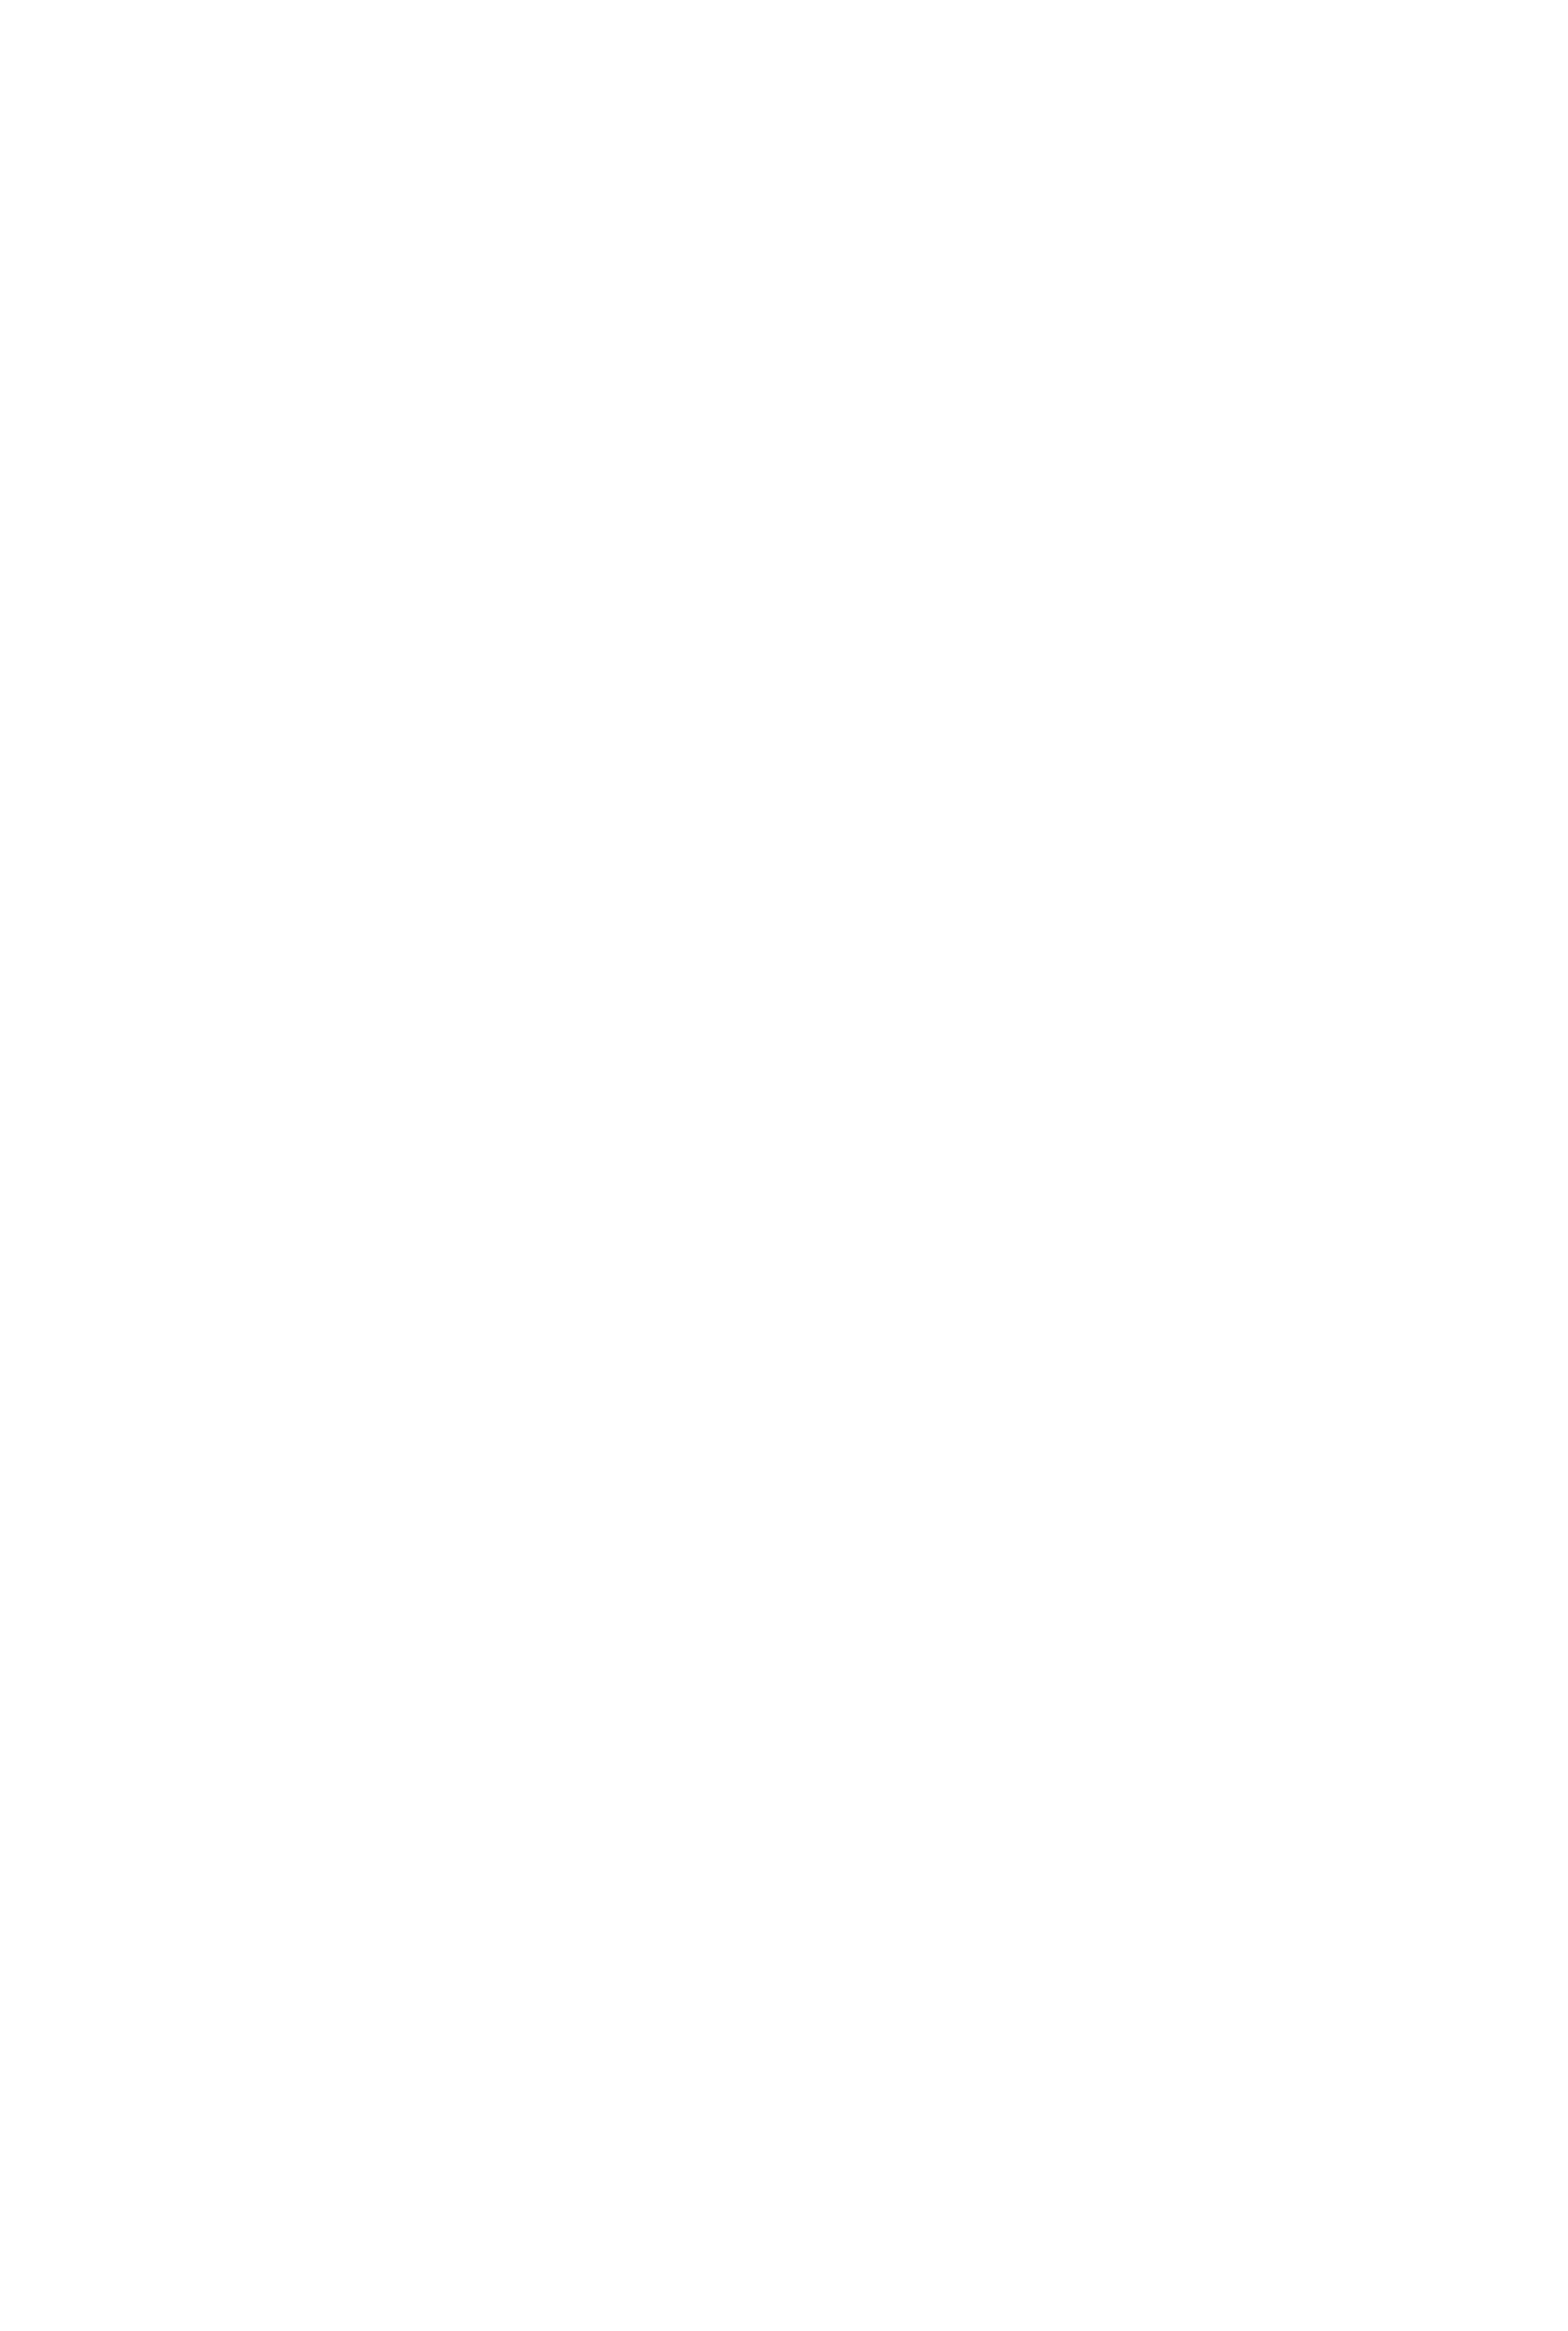

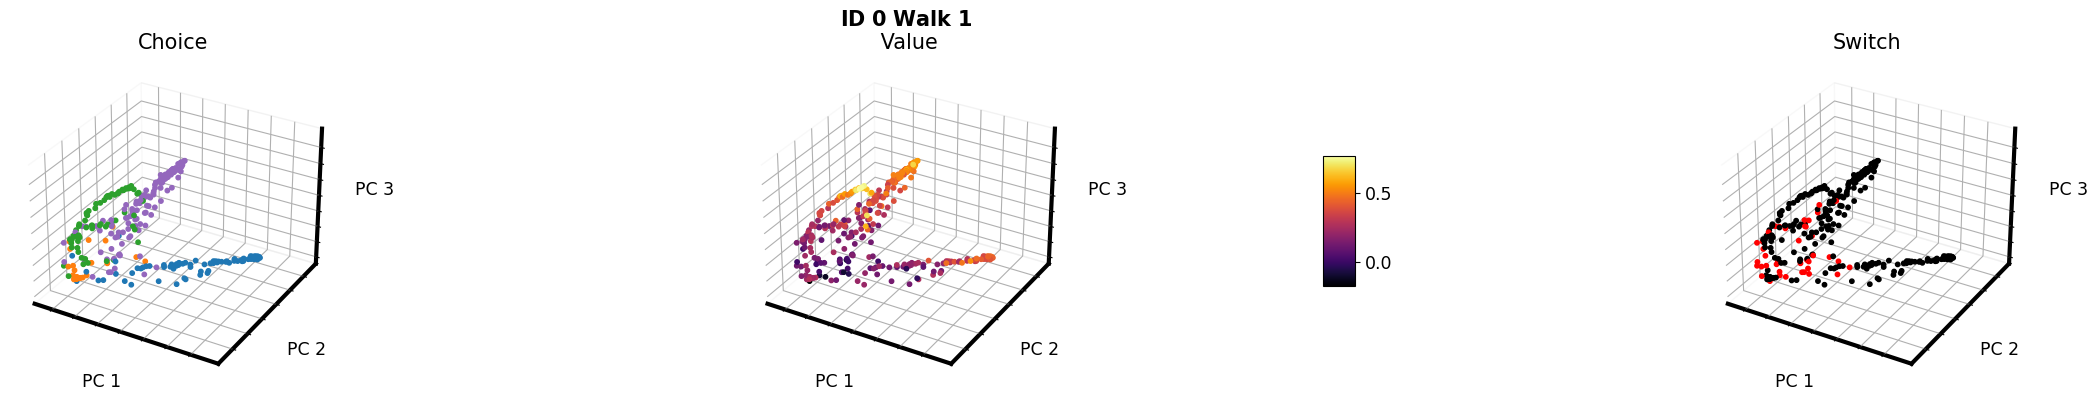

C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
1


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
2


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
3


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
4


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
5


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
6


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
7


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
8


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
9


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
10


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
11


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
12


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
13


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

6
14


C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
C:\Users\deniz\AppData\Local\anaconda3\envs\rnn\lib\site-packages\ipykernel_launcher.py:172: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() i

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001D8286FB620> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x000001D8286FB2F0> (for post_execute):


KeyboardInterrupt: 

In [50]:
plt.axis('off')

rnn_file_path = PATH_RNN_DATA + RNN_FILE_NAME

# counter for row of image
i = 0
# counter for image file
j = 0

#create figure
fig = plt.figure()
# spec = gridspec.GridSpec(ncols=4, nrows=9, figure=fig, width_ratios = [1,1,0.15,1], hspace = 0.5)
spec = gridspec.GridSpec(ncols=4, nrows=9, figure=fig, width_ratios = [1,1,0.2,1])



for id_ in range(N_IDS):
    for walk in range(1, N_WALKS+1):

        d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
        df = d.reset_index()

        # init pca object
        pca = PCA()
        # get hidden unit activity of RNN
        hidden_units = df.loc[:, [col.startswith('rnn_state') for col in df.columns.values]]
        # standardize hidden unit activity
        st_hidden = StandardScaler().fit_transform(hidden_units)  
        # calculate principal components
        pcs = pca.fit_transform(st_hidden)

        # get x,y,z coordinates
        X, Y, Z = pcs[:,0], pcs[:,1], pcs[:,2] 

        #create figure
        #fig = plt.figure()
        
        # create main title
        #fig.suptitle('RNN ID {} Walk {}'.format(id_, walk), y = 0.75)

        # create color for choices 
        choices = df['choice'].to_numpy()
        my_ch_cols = ['tab:blue','tab:orange','tab:green','tab:purple']
        ch_col = [my_ch_cols[choices[t]] for t in range(N_TRIALS)]
    
        # create color for switches
        is_switch = df['is_switch'].to_numpy()
        my_sw_cols = ['black', 'red']
        sw_col = [my_sw_cols[is_switch[t]] for t in range(N_TRIALS)]
        
        ###############
        # First plot  #
        ###############
#         #spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig, width_ratios = [1,1,0.2,1])
#         #gridspec = {'width_ratios': [1, 1, 0.1, 1]}
        
#         #ax = fig.add_subplot(131, projection='3d')
#         ax = fig.add_subplot(spec[i,0], projection='3d')
        
#         ax.scatter(X,Y,Z, color= ch_col, alpha = my_alpha, s = my_dot_size)
#         ax.set_title('Choice', fontsize = my_font_size)

#         # styling
#         ax.w_xaxis.pane.fill, ax.w_yaxis.pane.fill , ax.w_zaxis.pane.fill  = False, False, False
#         ax.xaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         ax.yaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         ax.zaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
#             axis.line.set_linewidth(3)

#         # labels
#         ax.set_xlabel('PC 1', fontsize = my_font_size)
#         ax.set_ylabel('PC 2', fontsize = my_font_size)
#         ax.set_zlabel('PC 3', fontsize = my_font_size)

### NEW
        #spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig, width_ratios = [1,1,0.2,1])
        #gridspec = {'width_ratios': [1, 1, 0.1, 1]}
        
        #ax = fig.add_subplot(131, projection='3d')
        ax = fig.add_subplot(spec[i,0], projection='3d')
        
        ax.scatter(X,Y,Z, color= ch_col, alpha = my_alpha, s = my_dot_size)
        ax.set_title('Choice')

        # styling
        ax.w_xaxis.pane.fill, ax.w_yaxis.pane.fill , ax.w_zaxis.pane.fill  = False, False, False
        ax.xaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        ax.yaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        ax.zaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
            axis.line.set_linewidth(3)

        # labels
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
                
        #############
        # 2nd plot  #
        #############
#         ax = fig.add_subplot(spec[i,1], projection='3d')
#         x = ax.scatter(X,Y,Z, c= df['value'], alpha = my_alpha, cmap = 'inferno', label = 'Value',  s = my_dot_size)
#         ax.set_title( r"$\bf{"+'ID'+"}$" + " " + r"$\bf{"+str(id_)+"}$" +" "+ r"$\bf{"+'Walk'+"}$" + " "+ r"$\bf{"+str(walk)+"}$"
#                      + '\n Value', fontsize = my_font_size)

#         # styling
#         ax.w_xaxis.pane.fill, ax.w_yaxis.pane.fill , ax.w_zaxis.pane.fill  = False, False, False
#         ax.xaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         ax.yaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         ax.zaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
#             axis.line.set_linewidth(3)
        
#         # labels
#         ax.set_xlabel('PC 1', fontsize = my_font_size)
#         ax.set_ylabel('PC 2', fontsize = my_font_size)
#         ax.set_zlabel('PC 3', fontsize = my_font_size)

### NEW

        ax = fig.add_subplot(spec[i,1], projection='3d')
        x = ax.scatter(X,Y,Z, c= df['value'], alpha = my_alpha, cmap = 'inferno', label = 'Value',  s = my_dot_size)
        ax.set_title( r"$\bf{"+'ID'+"}$" + " " + r"$\bf{"+str(id_)+"}$" +" "+ r"$\bf{"+'Walk'+"}$" + " "+ r"$\bf{"+str(walk)+"}$"
                     + '\n Value')

        # styling
        ax.w_xaxis.pane.fill, ax.w_yaxis.pane.fill , ax.w_zaxis.pane.fill  = False, False, False
        ax.xaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        ax.yaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        ax.zaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
            axis.line.set_linewidth(3)
        
        # labels
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
    
        #####################################
        # 3rd plot = colorbar for 2nd plot  #
        #####################################
#         ax = fig.add_subplot(spec[i,2])
# #         axins = inset_axes(ax,
# #             width="25%",  
# #             height="40%",
# #             loc='center left',
# #             borderpad=0
# #            )
        
#         axins = inset_axes(ax,
#         width="25%",  
#         height="100%",
#         loc='center left',
#         borderpad=0
#         )
        
#         plt.colorbar(x,cax = axins)    
#         ax.axis('off')
#         axins.tick_params(labelsize = 30)

### NEW

        ax = fig.add_subplot(spec[i,2])
        axins = inset_axes(ax,
            width="25%",  
            height="40%",
            loc='center left',
            borderpad=0
           )
        
        plt.colorbar(x,cax = axins)    
        ax.axis('off')
    
        #############
        # 4rd plot  #
        #############
#         ax = fig.add_subplot(spec[i,3], projection='3d')
#         ax.scatter(X,Y,Z, color = sw_col, alpha = my_alpha,  s = my_dot_size)
#         ax.set_title('Switch', fontsize = my_font_size)

#         # styling
#         ax.w_xaxis.pane.fill, ax.w_yaxis.pane.fill , ax.w_zaxis.pane.fill  = False, False, False
#         ax.xaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         ax.yaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         ax.zaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
#         for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
#             axis.line.set_linewidth(3)
#         # labels
#         ax.set_xlabel('PC 1', fontsize = my_font_size)
#         ax.set_ylabel('PC 2', fontsize = my_font_size)
#         ax.set_zlabel('PC 3', fontsize = my_font_size)

### NEW
        ax = fig.add_subplot(spec[i,3], projection='3d')
        ax.scatter(X,Y,Z, color = sw_col, alpha = my_alpha,  s = my_dot_size)
        ax.set_title('Switch')

        # styling
        ax.w_xaxis.pane.fill, ax.w_yaxis.pane.fill , ax.w_zaxis.pane.fill  = False, False, False
        ax.xaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        ax.yaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        ax.zaxis.set_tick_params(labelcolor='white', grid_alpha = 0, zorder = 1, labelsize = 0.1)
        for axis in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
            axis.line.set_linewidth(3)
        # labels
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
        
        # increment
        i +=1
        
        # periodically save
        if (i)%6==0:
            print(i)
            print(j+1)
            # save figure
            #plt.savefig('../p1_generalization/plots/3d_plot_all_{}_t.png'.format(j+1), dpi = 300, bbox_inches='tight')
            # reset row counter
            i = 0
            # increment plot counter
            j +=1

            #create figure
            fig = plt.figure()
            #spec = gridspec.GridSpec(ncols=4, nrows=9, figure=fig, width_ratios = [1,1,0.15,1], hspace = 0.5) # save 9*4 grid
            spec = gridspec.GridSpec(ncols=4, nrows=9, figure=fig, width_ratios = [1,1,0.2,1]) # save 9*4 grid

        
#         # save figure
        if id_ == 0:
            plt.savefig('../p1_generalization/plots/test_3d_plot_id_{}_walk_{}.png'.format(id_, walk), dpi = 300, bbox_inches='tight')
            plt.show()
            break